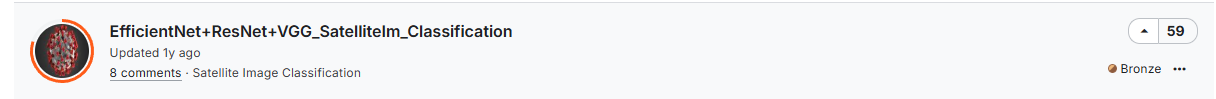

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization


In [3]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels


def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


def create_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

In [5]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= 40)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= 40)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= 40)
    return train_gen, valid_gen, test_gen


dir = 'D:\code_study\ML_CODE\dataSets\Satellite Image Classification\data'
dir = dir.replace('\\', '/')

df = create_df(dir)
train_df, test_valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

# Get Generators
batch_size = 200
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 4504 validated image filenames belonging to 4 classes.
Found 564 validated image filenames belonging to 4 classes.
Found 563 validated image filenames belonging to 4 classes.


In [9]:
train_df

,filepaths,labels
3209,D:/code_study/ML_CODE/dataSets/Satellite Image...,green_area
2077,D:/code_study/ML_CODE/dataSets/Satellite Image...,desert
2131,D:/code_study/ML_CODE/dataSets/Satellite Image...,desert
2254,D:/code_study/ML_CODE/dataSets/Satellite Image...,desert
4998,D:/code_study/ML_CODE/dataSets/Satellite Image...,water
...,...,...
3772,D:/code_study/ML_CODE/dataSets/Satellite Image...,green_area
5191,D:/code_study/ML_CODE/dataSets/Satellite Image...,water
5226,D:/code_study/ML_CODE/dataSets/Satellite Image...,water
5390,D:/code_study/ML_CODE/dataSets/Satellite Image...,water


In [7]:
test_df

,filepaths,labels
5102,D:/code_study/ML_CODE/dataSets/Satellite Image...,water
4507,D:/code_study/ML_CODE/dataSets/Satellite Image...,water
3787,D:/code_study/ML_CODE/dataSets/Satellite Image...,green_area
437,D:/code_study/ML_CODE/dataSets/Satellite Image...,cloudy
1988,D:/code_study/ML_CODE/dataSets/Satellite Image...,desert
...,...,...
1773,D:/code_study/ML_CODE/dataSets/Satellite Image...,desert
4085,D:/code_study/ML_CODE/dataSets/Satellite Image...,green_area
43,D:/code_study/ML_CODE/dataSets/Satellite Image...,cloudy
5277,D:/code_study/ML_CODE/dataSets/Satellite Image...,water


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/10
113/113 [==============================] - 26s 177ms/step - loss: 0.5346 - accuracy: 0.8146 - val_loss: 0.0896 - val_accuracy: 0.9716

Epoch 00001: val_accuracy improved from -inf to 0.97163, saving model to best_model.h5
Epoch 2/10
113/113 [==============================] - 17s 153ms/step - loss: 0.1860 - accuracy: 0.9383 - val_loss: 0.0418 - val_accuracy: 0.9787

Epoch 00002: val_accuracy improved from 0.97163 to 0.97872, saving model to best_model.h5
Epoch 3/10
113/113 [==============================] - 17s 153ms/step - loss: 0.1416 - accuracy: 0.9479 - val_loss: 0.0344 - val_accuracy: 0.9840

Epoch 00003: val_accuracy improved from 0.97872 to 0.98404, saving model to best_model.h5
Epoch 4/10
113/113 [==============================] - 17s 153ms/step - loss: 0.1412 - accuracy: 0.9549 - val_loss: 0.0324 - val_accuracy: 0.9858

Epoch 00004: val_accuracy improved from 0.98404 to 0.98582, saving model to best_model.h5
Epoch 5/10
113/113 [==============================] - 17s 1

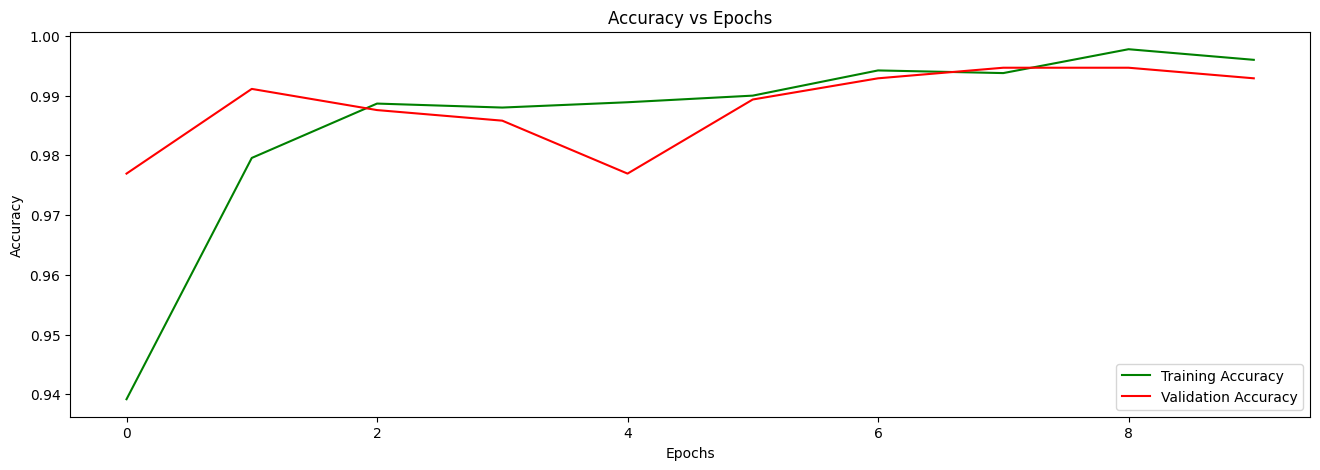

In [16]:
import matplotlib.pyplot as plt
# accuracy and loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(16, 5))
plt.plot(epochs_range, accuracy, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='red')
plt.legend(loc='lower right')
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

563/563 [==============================] - 3s 4ms/step - loss: 0.0648 - accuracy: 0.9805
Train Loss:  0.01950150355696678
Train Accuracy:  0.991563081741333
--------------------
Validation Loss:  0.029216455295681953
Validation Accuracy:  0.98758864402771
--------------------
Test Loss:  0.0647883266210556
Test Accuracy:  0.980461835861206


In [12]:
model = load_model('best_model.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

c:\Users\Leaper\anaconda3\envs\tensorflowGpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[3 3 3 0 1 3 1 2 3 3 2 3 0 2 0 1 0 1 2 2 1 2 3 0 1 2 2 3 0 2 1 0 0 3 0 2 2
 0 3 3 3 3 0 3 3 0 3 3 3 2 0 1 3 1 2 0 0 2 0 3 2 0 0 2 1 1 3 0 2 0 3 3 1 2
 2 0 1 3 2 0 3 0 2 3 3 0 1 1 3 2 2 3 2 0 3 0 3 1 0 3 1 1 3 1 0 2 3 1 3 3 2
 1 3 0 0 2 0 3 2 1 3 3 2 0 0 3 2 2 2 1 3 1 3 2 3 3 1 0 1 3 2 0 0 1 2 0 0 0
 3 0 0 3 2 2 1 0 0 2 3 0 0 1 2 3 0 2 0 3 0 2 2 0 0 0 2 3 1 3 0 2 2 2 2 2 0
 3 0 0 2 3 1 1 0 3 1 0 1 0 2 0 0 2 1 3 0 1 0 1 3 3 3 1 0 3 0 2 2 0 2 1 0 0
 3 0 3 0 1 1 0 2 3 2 0 2 0 1 2 0 1 0 0 3 3 1 0 0 0 2 0 1 1 0 3 0 0 2 1 1 3
 3 0 0 1 0 0 3 2 0 1 3 2 3 0 1 0 0 2 3 0 0 0 1 3 1 1 1 3 2 3 3 0 0 2 0 3 2
 2 3 0 3 3 3 0 0 2 2 1 2 1 2 3 1 3 3 0 3 3 2 1 1 0 1 3 0 0 3 0 0 2 2 3 3 0
 0 2 2 1 3 3 1 3 3 0 2 0 3 0 0 2 3 2 3 1 2 3 1 1 1 3 3 2 0 2 1 3 1 1 3 2 0
 2 1 3 0 0 1 2 3 3 2 1 2 1 0 2 2 3 0 2 3 0 3 0 3 1 1 2 1 0 2 2 0 0 0 2 3 3
 2 0 0 0 0 2 0 2 3 2 2 0 0 2 1 3 0 3 0 0 3 1 3 2 1 2 3 1 2 0 1 2 0 0 1 1 1
 0 1 1 2 3 3 2 3 2 1 0 0 1 0 2 3 0 2 3 2 2 0 3 2 1 0 3 2 1 3 2 2 2 2 0 1 0
 2 0 1 1 1 2 0 1 3 0 3 2 

In [13]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[164   2   0   0]
 [  0 108   0   0]
 [  0   0 134   1]
 [  4   0   4 146]]
              precision    recall  f1-score   support

           1       0.98      0.99      0.98       166
           2       0.98      1.00      0.99       108
           3       0.97      0.99      0.98       135
           4       0.99      0.95      0.97       154

    accuracy                           0.98       563
   macro avg       0.98      0.98      0.98       563
weighted avg       0.98      0.98      0.98       563



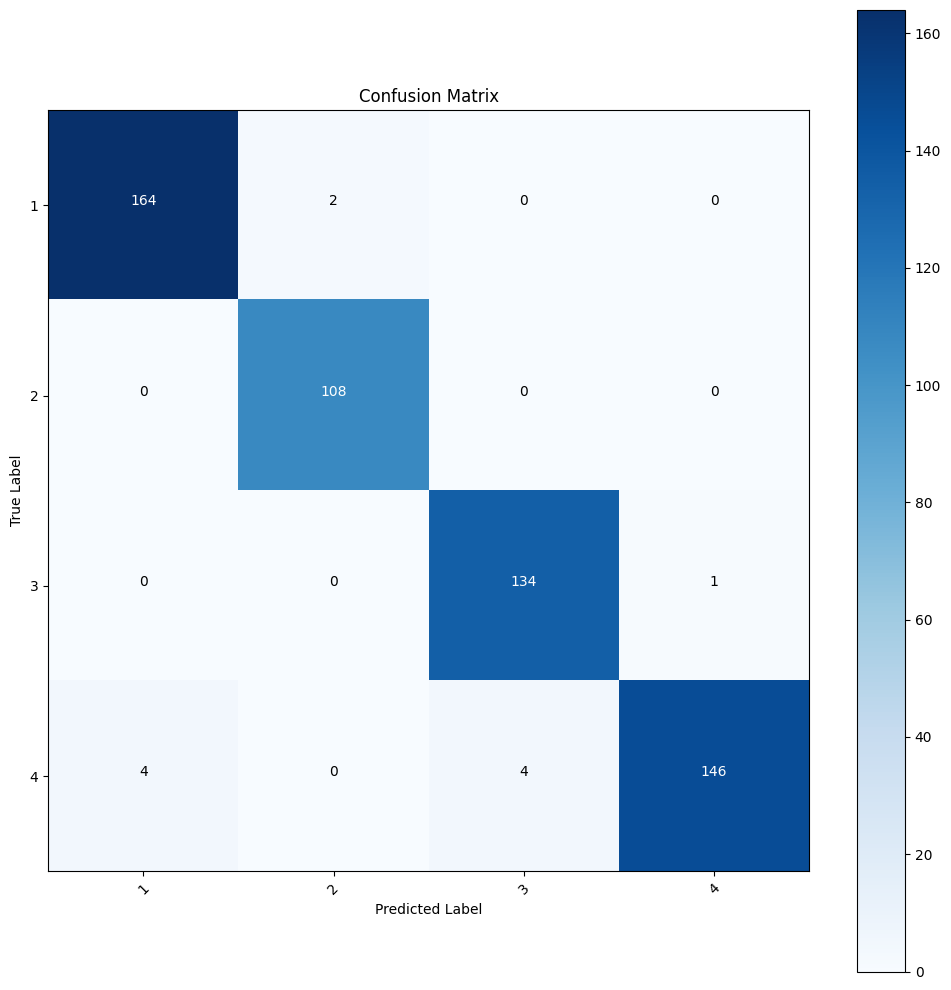

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['1','2','3','4']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/10
113/113 [==============================] - 21s 163ms/step - loss: 0.4285 - accuracy: 0.8573 - val_loss: 0.0858 - val_accuracy: 0.9770

Epoch 00001: val_accuracy improved from -inf to 0.97695, saving model to best_model_resnet.h5
Epoch 2/10
113/113 [==============================] - 17s 147ms/step - loss: 0.1039 - accuracy: 0.9771 - val_loss: 0.0319 - val_accuracy: 0.9911

Epoch 00002: val_accuracy improved from 0.97695 to 0.99113, saving model to best_model_resnet.h5
Epoch 3/10
113/113 [==============================] - 16s 144ms/step - loss: 0.0397 - accuracy: 0.9888 - val_loss: 0.0495 - val_accuracy: 0.9876

Epoch 00003: val_accuracy did not improve from 0.99113
Epoch 4/10
113/113 [==============================] - 17s 147ms/step - loss: 0.0386 - accuracy: 0.9893 - val_loss: 0.0766 - val_accuracy: 0.9858

Epoch 00004: val_accuracy did not improve from 0.99113
Epoch 5/10
113/113 [==============================] - 17s 149ms/step - loss: 0.0487 - accuracy: 0.9853 - val_loss: 

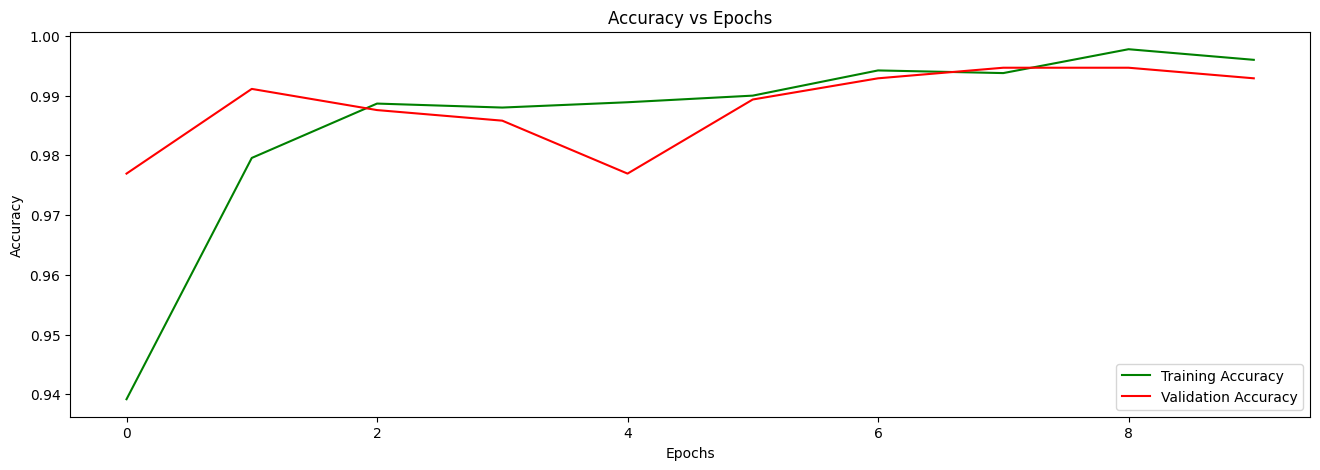

In [18]:
# accuracy and loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(16, 5))
plt.plot(epochs_range, accuracy, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='red')
plt.legend(loc='lower right')
plt.title('Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_resnet.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

563/563 [==============================] - 2s 4ms/step - loss: 0.0038 - accuracy: 0.9982
Train Loss:  0.00038534405757673085
Train Accuracy:  1.0
--------------------
Validation Loss:  0.01247097086161375
Validation Accuracy:  0.9946808218955994
--------------------
Test Loss:  0.0038240456487983465
Test Accuracy:  0.9982237815856934
